In [119]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Flatten, TimeDistributed, Activation, BatchNormalization, RepeatVector
from keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.preprocessing import MinMaxScaler

In [120]:
## fix random seed for reproducibility
seed = 7
np.random.seed(seed)

In [121]:
data = pd.read_csv('./bike.csv', thousands = ',')
y = pd.DataFrame(data.parkingBikeTotCnt)
y = y.dropna()
y = y[:1850]
y.shape

(1850, 1)

In [122]:
scaler = MinMaxScaler(feature_range=(-1, 1))
y = scaler.fit_transform(y)
y.shape

(1850, 1)

In [123]:
p1 = int(len(y) * 0.8)

train, test = y[:p1],  y[p1:]
print(len(train), len(test))

1480 370


/opt/conda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:211: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.6/site-packages/matplotlib/backends/backend_agg.py:180: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


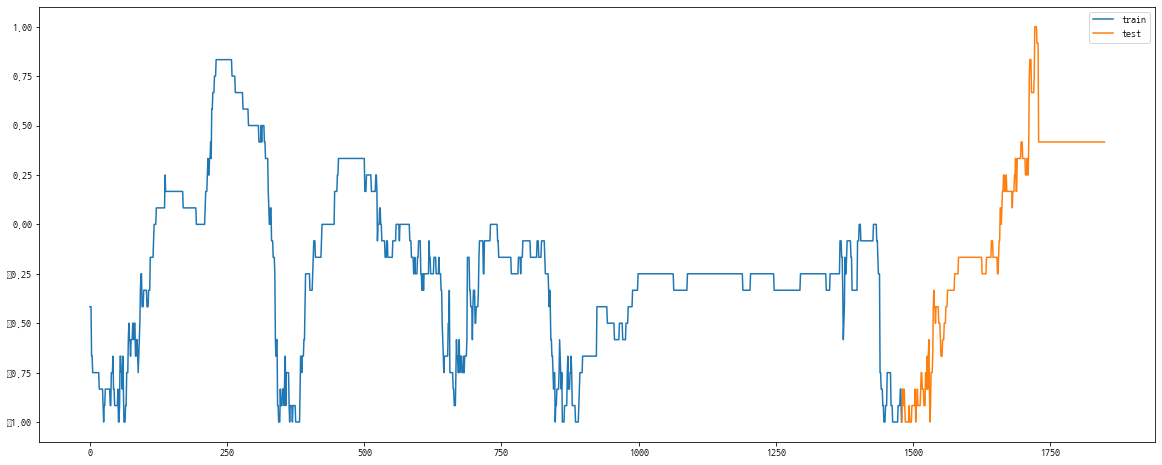

In [124]:
plt.figure(figsize=(20, 8))
plt.plot(range(0, p1), train, label="train")
plt.plot(range(p1, len(y)), test, label="test")

plt.legend()

In [125]:
def create_dataset(dataset, look_back=5, nPredicted = 5):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-nPredicted + 1):
		dataX.append(dataset[i:(i+look_back), 0])
		dataY.append(dataset[i + look_back: i + look_back + nPredicted, 0])
	return np.array(dataX), np.array(dataY)

In [126]:
look_back = 5
nPredicted = 5

trainX, trainY = create_dataset(train, look_back, nPredicted)
testX, testY = create_dataset(test, look_back, nPredicted)

In [127]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

trainY = np.reshape(trainY, (trainY.shape[0], trainY.shape[1], 1))
testY = np.reshape(testY, (testY.shape[0], testY.shape[1], 1))

print(trainX.shape, trainY.shape)

(1471, 5, 1) (1471, 5, 1)


In [128]:
model = Sequential()

model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model.add(RepeatVector(nPredicted))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))

# Adam = optimizers.Adam(lr=1e-5)
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_64 (LSTM)               (None, 50)                10400     
_________________________________________________________________
repeat_vector_47 (RepeatVect (None, 5, 50)             0         
_________________________________________________________________
lstm_65 (LSTM)               (None, 5, 50)             20200     
_________________________________________________________________
time_distributed_18 (TimeDis (None, 5, 1)              51        
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [129]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])

Train on 1176 samples, validate on 295 samples
Epoch 1/100
1176/1176 [==============================] - 11s 9ms/step - loss: 0.1731 - val_loss: 0.0622
Epoch 2/100
1176/1176 [==============================] - 1s 552us/step - loss: 0.0487 - val_loss: 0.0255
Epoch 3/100
1176/1176 [==============================] - 1s 544us/step - loss: 0.0237 - val_loss: 0.0159
Epoch 4/100
1176/1176 [==============================] - 1s 542us/step - loss: 0.0153 - val_loss: 0.0142
Epoch 5/100
1176/1176 [==============================] - 1s 555us/step - loss: 0.0134 - val_loss: 0.0139
Epoch 6/100
1176/1176 [==============================] - 1s 542us/step - loss: 0.0121 - val_loss: 0.0135
Epoch 7/100
1176/1176 [==============================] - 1s 542us/step - loss: 0.0124 - val_loss: 0.0125
Epoch 8/100
1176/1176 [==============================] - 1s 541us/step - loss: 0.0112 - val_loss: 0.0123
Epoch 9/100
1176/1176 [==============================] - 1s 541us/step - loss: 0.0109 - val_loss: 0.0132
Epoch 10/

((365, 1), (361, 5))

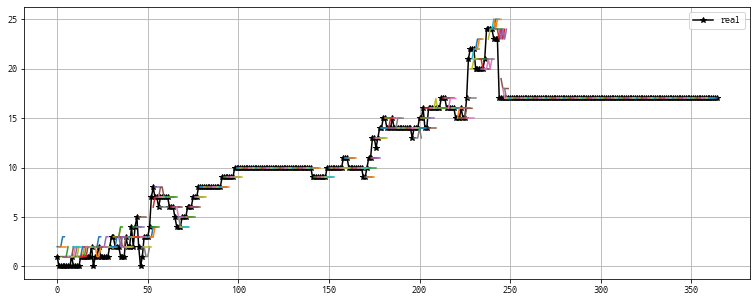

In [130]:
pred = model.predict(testX, batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
pred = np.around(pred)

plt.figure(figsize=(13, 5))
plt.grid(True)

real = scaler.inverse_transform(test[look_back:])

plt.plot(real, "*-", label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i])

real.shape, pred.shape

((305, 1), (300, 5))

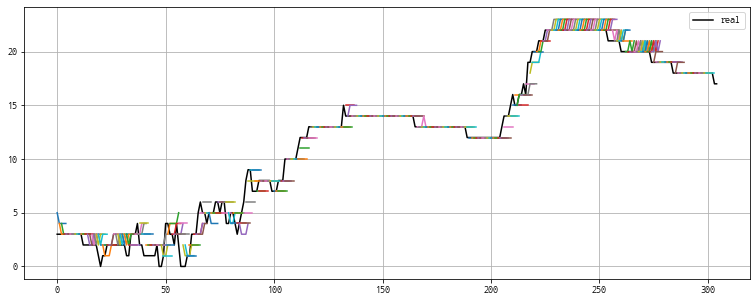

In [131]:
pred = model.predict(trainX[:300], batch_size=1)
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
pred = scaler.inverse_transform(pred)
pred = np.around(pred)

plt.figure(figsize=(13, 5))
plt.grid(True)

real = scaler.inverse_transform(train[look_back:300+ look_back + nPredicted])
plt.plot(real, label="real", color="black")
plt.legend()

for i in range(0, len(pred), 1):
  plt.plot(range(i, i + nPredicted), pred[i])

real.shape, pred.shape